In [43]:
import os 
import random
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2
import typing as t
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout, Attention,concatenate, Layer, TextVectorization, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
!mkdir visual_attn_model_ckpts

mkdir: cannot create directory ‘visual_attn_model_ckpts’: File exists


In [5]:
# !rm -r /kaggle/working

In [6]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [7]:
# !unzip /root/nltk_data/corpora/wordnet -d /root/nltk_data/corpora/

In [8]:
base_dir = '/kaggle/input/multimodal-hate-speech/'
print(os.listdir(base_dir))

['splits', 'img_resized', 'img_txt', 'hatespeech_keywords.txt', 'MMHS150K_readme.txt', 'MMHS150K_GT.json']


In [9]:
splits_path = os.path.join(base_dir, 'splits/')
print(os.listdir(splits_path))

['val_ids.txt', 'test_ids.txt', 'train_ids.txt']


In [10]:
##Function to read file IDs of train, val, test splits
def read_ids(path):
    with open(path) as f:
        lines = f.readlines()
        lines = [x.strip() for x in lines]
        
        return lines
    

In [11]:
train_id_path = os.path.join(splits_path, 'train_ids.txt')
val_id_path = os.path.join(splits_path, 'val_ids.txt')
test_id_path = os.path.join(splits_path, 'test_ids.txt')

train_ids = read_ids(train_id_path)
val_ids = read_ids(val_id_path)
test_ids = read_ids(test_id_path)

In [12]:
print(f"Training data size: {len(train_ids)}")
print(f"Validation data size: {len(val_ids)}")
print(f"Testing data size: {len(test_ids)}")

Training data size: 134823
Validation data size: 5000
Testing data size: 10000


In [13]:
img_dir = os.path.join(base_dir, 'img_resized')
text_dir = os.path.join(base_dir, 'img_txt')

In [14]:
##Check if there are any missing entries from either images or text
print(f"Number of images: {len(os.listdir(img_dir))}")
print(f"Number of text files: {len(os.listdir(text_dir))}")

Number of images: 150000
Number of text files: 59252


In [15]:
##Checking the images which dont have corresponding text files
remove_extension = lambda x : x.split('.')[0]

missing_text = set(map(remove_extension, os.listdir(img_dir))) - set(map(remove_extension, os.listdir(text_dir))) 

In [16]:
missing_text = list(missing_text)

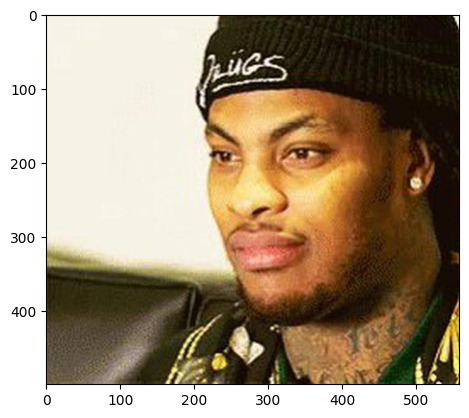

In [17]:
##Plotting an image randomly from those which dont have corresponding image texts
## Cell can be run multiple times to verify that these images don't have text
random_image = plt.imread(os.path.join(img_dir, random.choice(missing_text))+'.jpg')
plt.imshow(random_image)

## POSSIBLY NSFW CELL BELOW

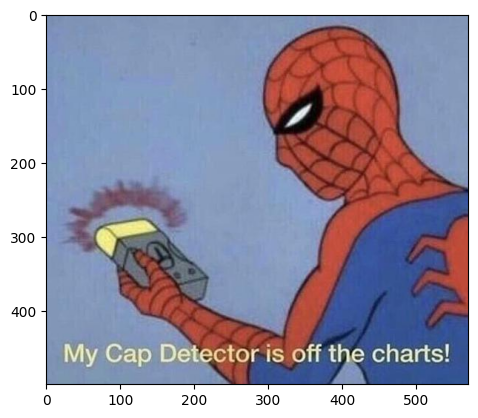

In [18]:
with_text_imgs = set(map(remove_extension, os.listdir(img_dir))).intersection(set(map(remove_extension, os.listdir(text_dir))))
with_text_imgs = list(with_text_imgs)

img_name = random.choice(with_text_imgs)
img_with_text_path = plt.imread(os.path.join(img_dir, img_name + '.jpg'))
plt.imshow(img_with_text_path)

In [19]:
print(os.path.join(text_dir, img_name + '.json'))

/kaggle/input/multimodal-hate-speech/img_txt/1115758679645671424.json


In [20]:
with open(os.path.join(text_dir, img_name + '.json')) as f:
    d = json.load(f)
    print(d)

{'img_text': 'My Cap Detector is off the charts! '}


In [21]:
def preprocess_text(text: str) -> str:
    
    # Convert to lowercase
    text = text.lower()

    # Non-word character Removal
    text = text.replace('[^\w\s]', '')
    
    # Digits Removal
    text = text.replace('\d', '')

    
    # Remove punctuation
    PUNCT_TO_REMOVE = string.punctuation
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    
    
    # Remove stopwords
    STOPWORDS = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in STOPWORDS])
    
    
    # Stem words
    stemmer = SnowballStemmer(language='english')
#     wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
#     pos_tagged_text = nltk.pos_tag(text.split())
    text = " ".join([stemmer.stem(word) for word in text.split()])
    

    # Remove URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    # Remove HTML tags
    html_pattern = re.compile('<.*?>')
    text = html_pattern.sub(r'', text)

    return text

def preprocess_text_from_path(path : str) -> str:
    
    try:
        with open(path) as f:
            d = json.load(f)
            text = d['img_text']
        
    except Exception as e:
        text = ''
    
#     return text
    return preprocess_text(text)

In [22]:
testext1='Hey there this is a test to see if this text preprocessor is working as intended'
preprocess_text(testext1)

'hey test see text preprocessor work intend'

In [23]:
labels_path = '/kaggle/input/multimodal-hate-speech/MMHS150K_GT.json'

In [24]:
def text_for_tokenizer(ids):
    all_texts = []
    
    
    for img_id in ids:
        
        try:
            txt_file_name = os.path.join(text_dir, img_id + '.json')

            with open(txt_file_name) as f:
                txt_dict = json.load(f)
            
            txt = txt_dict['img_text']
            processed_txt = preprocess_text(txt)
            all_texts.append(processed_txt)
            
        except Exception:
            txt = ''
            all_texts.append(txt)
            
            
    return all_texts

In [25]:
txt = text_for_tokenizer(train_ids)

In [26]:
training_texts = txt

In [27]:
max_features = 50000  #max number of tokens...the max number of unique words from our text data
sequence_length = 50 #output length..if some are not of this length they get padded

vectorization_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True)

vectorization_layer.adapt(training_texts)

In [28]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-09-13 12:17:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-09-13 12:17:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-09-13 12:17:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [29]:
embeddings_index = {}
f = open(os.path.join('./', 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


embedding_dim = 300

# Define the vocabulary size (should match your TextVectorization max_tokens)
vocab_size = len(vectorization_layer.get_vocabulary())

# Create an embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for i, word in enumerate(vectorization_layer.get_vocabulary()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [57]:
def binarize_labels(labels):
    
    binarized_labels = []
    
    for label_lst in labels:
        processed_lst = [1 if x != 0 and x != 1 else x for x in label_lst]
    
        # Count the number of 0s and 1s in the processed list
        count_0 = processed_lst.count(0)
        count_1 = processed_lst.count(1)
    
        # Return 0 if there are more 0s, otherwise return 1
        if count_0 > count_1:
            binarized_labels.append(0)
        else:
            binarized_labels.append(1)
    
    return binarized_labels

In [31]:
def preprocess_image(image_path):
    img = plt.imread(image_path)
    img = cv2.resize(img, (224,224))
    img = preprocess_input(img)
    img = img/255.0
    return img


def load_data(ids, batch_size = 32, mode = 'both', shuffle = False):
    
    image_paths = []
    text_paths = []
    labels = []
    

    for data_id in tqdm(ids):
            img_path = os.path.join(img_dir, data_id + '.jpg')
            text_path = os.path.join(text_dir, data_id + '.json')
            
            image_paths.append(img_path)
            text_paths.append(text_path)
    
    with open(labels_path) as f:
        label_dict = json.load(f)
        
    for data_id in ids:
#         print(data_id)
#         print(len(label_dict[data_id]['labels']))
        labels.append(label_dict[data_id]['labels'])
    
    num_samples = len(image_paths)
    indices = np.arange(num_samples)
    
    print(len(labels))
    
    if shuffle:
        np.random.shuffle(indices)

    while True:
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = np.array(indices[start_idx:end_idx], dtype = 'uint8')    
                        
            batch_images = [preprocess_image(image_paths[i]) for i in batch_indices]
            batch_images = np.array(batch_images)

            batch_texts = [preprocess_text_from_path(text_paths[i]) for i in batch_indices]
            batch_texts = vectorization_layer((np.array(batch_texts)))

            batch_labels = binarize_labels(np.array((labels), dtype = 'object')[batch_indices])
            
            if mode == 'both':
                yield (batch_images, batch_texts), np.array(batch_labels)
            elif mode == 'img':
                yield batch_images, np.array(batch_labels)
            elif mode == 'text':
                yield  batch_texts, np.array(batch_labels)
            else:
                raise Exception("Wrong mode specified")

In [32]:
train_data_generator = load_data(train_ids)

# To retrieve a batch of data:
batch_data, batch_labels = next(train_data_generator)
batch_images, batch_texts = batch_data

100%|██████████| 134823/134823 [00:00<00:00, 216261.86it/s]


134823


In [33]:
def text_feature_extractor(): 
    input_txt = Input(shape=(50,), dtype='int64')
    # print(input_txt
    txt = layers.Embedding(50000,
                            300,
                            weights=[embedding_matrix],
                            input_length=300,
                            trainable=False)(input_txt)
    text_lstm = layers.Bidirectional(layers.LSTM(256,return_sequences=True))(txt)
    text_lstm = layers.Bidirectional(layers.LSTM(128,return_sequences=True))(text_lstm)
    text_lstm = layers.Bidirectional(layers.LSTM(64,return_sequences=False))(text_lstm)
    attention_layer = Attention(use_scale = True)([text_lstm, text_lstm])
    text_flatten = Flatten()(attention_layer)
    fc_layer = Dense(512, activation='relu')(text_flatten)
    fc_layer = Dropout(0.3)(fc_layer)
    fc_layer = Dense(128, activation = 'relu')(fc_layer)
    fc_layer = Dropout(0.3)(fc_layer)
    out_layer = Dense(64, activation = 'relu')(fc_layer)
    # merged = concatenate([text_lstm,flatten], axis=1)
    
    
#     return text_layer 
    return Model(inputs = input_txt, outputs = out_layer)

In [49]:
def create_image_feature_extractor(input_shape=(224, 224, 3)):
    
    # Define the input layer
    input_tensor = Input(shape=input_shape)
    
    conv = Conv2D(32, 2, activation = 'relu')(input_tensor)
    bn = BatchNormalization()(conv)
    mp = MaxPooling2D((2,2))(bn)
    
    conv = Conv2D(32, 2, activation = 'relu')(mp)
    bn = BatchNormalization()(conv)
    mp = MaxPooling2D((2,2))(bn)

    visual_attention = Attention(use_scale = True)([mp, mp])
    
    visual_attention = Flatten()(visual_attention)
    
    op = Dense(64)(visual_attention)
    
    feature_extractor = Model(inputs = input_tensor, outputs = op, name = 'image_feature_extractor')
    
    return feature_extractor

In [35]:
text_attn = text_feature_extractor()
text_attn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      15000000    ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 50, 512)      1140736     ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 50, 256)     656384      ['bidirectional[0][0]']          
 )                                                                                            

In [50]:
cnn_attention = create_image_feature_extractor()
cnn_attention.summary()

Model: "image_feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 223, 223, 32  416         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 223, 223, 32  128        ['conv2d_4[0][0]']               
 rmalization)                   )                                           

In [51]:
def visual_attention_model():
    model = Sequential()
    
    img_fe = create_image_feature_extractor()
    
    model.add(img_fe)
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

def multimodal_attention_model():
    input_image = Input(shape=(224, 224, 3))
    input_text = Input(shape = (50), dtype='int64')  

    img_fe = create_image_feature_extractor()
    text_fe = text_feature_extractor()

    image_features = img_fe(input_image)
    text_features = text_fe(input_text)
    
    merged_features = concatenate([image_features, text_features])

    output = Dense(1, activation='sigmoid')(merged_features)

    multimodal_model = Model(inputs=[input_image, input_text], outputs=output)

    return multimodal_model

def semantic_attention_model():
    
    model = Sequential()
    
    text_fe = text_feature_extractor()
    
    model.add(text_fe)
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [52]:
visual_attention_model = visual_attention_model()

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

ckpt = ModelCheckpoint(
    filepath='/kaggle/working/visual_attn_model_ckpts/best_model.h5',  # Filepath to save the model weights.
    monitor='val_loss',  
    save_best_only=True, 
    save_weights_only=True,  
    mode='min',  
    verbose=1  
)
visual_attention_model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [53]:
epochs = 50

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

# Training data loader
train_data_loader = load_data(train_ids, mode = 'img')  # Replace with your data loader function

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'img')  # Replace with your validation data loader function

# Train the model using model.fit
history = visual_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)


100%|██████████| 134823/134823 [00:00<00:00, 211547.88it/s]


134823
Epoch 1/50
 557/4213 [==>...........................] - ETA: 15:37 - loss: 0.1209

KeyboardInterrupt: 

In [ ]:
!semantic_attn_model_ckpts

semantic_attention_model = semantic_attention_model()

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

ckpt = ModelCheckpoint(
    filepath='/kaggle/working/semantic_attn_model_ckpts/best_model.h5',  # Filepath to save the model weights.
    monitor='val_loss',  
    save_best_only=True, 
    save_weights_only=True,  
    mode='min',  
    verbose=1  
)
semantic_attention_model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [ ]:
epochs = 50

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

# Training data loader
train_data_loader = load_data(train_ids, mode = 'text')  # Replace with your data loader function

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'text')  # Replace with your validation data loader function

# Train the model using model.fit
history = semantic_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)


New Multimodal for text and images